In [647]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

import sklearn
import pandas as pd

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics

In [648]:
#reading Building1.csv

electricity_data = pd.read_csv("citylearn_challenge_2023_phase_1/Building_1.csv")
print(electricity_data)

     month  hour  ...  indoor_dry_bulb_temperature_set_point  hvac_mode
0        6     1  ...                              23.222221          1
1        6     2  ...                              22.222221          1
2        6     3  ...                              22.222221          1
3        6     4  ...                              22.222221          1
4        6     5  ...                              22.222221          1
..     ...   ...  ...                                    ...        ...
715      6    20  ...                              24.444445          1
716      6    21  ...                              24.444445          1
717      6    22  ...                              24.444445          1
718      6    23  ...                              24.444445          1
719      6    24  ...                              21.666666          1

[720 rows x 15 columns]


In [649]:
carbon_data = pd.read_csv("citylearn_challenge_2023_phase_1/carbon_intensity.csv")
print(carbon_data)

     carbon_intensity
0            0.402488
1            0.382625
2            0.369458
3            0.367017
4            0.374040
..                ...
715          0.465811
716          0.470324
717          0.462414
718          0.448648
719          0.428057

[720 rows x 1 columns]


In [650]:
pricing_data = pd.read_csv("citylearn_challenge_2023_phase_1/pricing.csv")
print(pricing_data)

     electricity_pricing  ...  electricity_pricing_predicted_24h
0                0.02893  ...                            0.02893
1                0.02893  ...                            0.02893
2                0.02893  ...                            0.02893
3                0.02893  ...                            0.02893
4                0.02893  ...                            0.02893
..                   ...  ...                                ...
715              0.02893  ...                            0.02893
716              0.02893  ...                            0.02893
717              0.02893  ...                            0.02893
718              0.02893  ...                            0.02893
719              0.02893  ...                            0.02893

[720 rows x 4 columns]


In [651]:
weather_data = pd.read_csv("citylearn_challenge_2023_phase_1/weather.csv")
print(weather_data)

     outdoor_dry_bulb_temperature  ...  direct_solar_irradiance_predicted_24h
0                           24.66  ...                                    0.0
1                           24.07  ...                                    0.0
2                           23.90  ...                                    0.0
3                           23.87  ...                                    0.0
4                           23.83  ...                                    0.0
..                            ...  ...                                    ...
715                         31.98  ...                                    0.0
716                         29.92  ...                                    0.0
717                         28.48  ...                                    0.0
718                         27.27  ...                                    0.0
719                         26.26  ...                                    0.0

[720 rows x 16 columns]


In [652]:
df = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)
print(df)

     month  ...  direct_solar_irradiance_predicted_24h
0        6  ...                                    0.0
1        6  ...                                    0.0
2        6  ...                                    0.0
3        6  ...                                    0.0
4        6  ...                                    0.0
..     ...  ...                                    ...
715      6  ...                                    0.0
716      6  ...                                    0.0
717      6  ...                                    0.0
718      6  ...                                    0.0
719      6  ...                                    0.0

[720 rows x 36 columns]


In [653]:
def create_model_large():
    # create model
    model = Sequential()
    #your code here	
    model.add(Dense(35, input_dim = X_train.shape[1], activation = 'relu'))
    model.add(Dense(70, activation = 'relu'))
    model.add(Dense(35, activation = 'relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss = 'mean_squared_error', metrics = [metrics.mae])
    
    return model

In [654]:
def NRMSE(real, pred):
    return sqrt(mean_squared_error(real, pred)/(real.max() - real.min()))

In [655]:
# Funzione per calcolare NRMSE per una singola variabile con finestra temporale
#per facilitarmi ho cercato di calcolare lo ScoreForecast come se avessi una sola variabile
#poi come si vede in fondo al file faccio una classica media sugli nrmse calcolati in questo modo

def NRMSE_window_single_variable(real, pred, w):
    num_timesteps = len(real)  # Total number of time steps, quindi quello che è indicato con n
    nrmse_windows = []  # Lista per raccogliere gli NRMSE di ciascuna finestra, quindi dalla formula la sommatoria sotto radice
    
    # Itero su ogni finestra temporale
    for t in range(num_timesteps - w + 1):
        #qui cerco di trovare quello che in teoria definisce ft,τv: Forecast of variable v for time step t+τ, made at time t;
        
        real_window = real[t:t+w]
        pred_window = pred[t:t+w]
        
        # Calcolo l'NRMSE tra i valori reali e predetti della finestra e lo aggiungo alla lista
        nrmse_windows.append(NRMSE(real_window, pred_window))
    
    # Restituisco infine la media degli NRMSE per tutte le finestre temporali
    return np.mean(nrmse_windows)

In [656]:
# Descriptive statistics summary
df.describe()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,heating_demand,solar_generation,occupant_count,indoor_dry_bulb_temperature_set_point,hvac_mode,carbon_intensity,electricity_pricing,electricity_pricing_predicted_6h,electricity_pricing_predicted_12h,electricity_pricing_predicted_24h,outdoor_dry_bulb_temperature,outdoor_relative_humidity,diffuse_solar_irradiance,direct_solar_irradiance,outdoor_dry_bulb_temperature_predicted_6h,outdoor_dry_bulb_temperature_predicted_12h,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
count,720.0,720.000000,720.000000,720.0,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.0,720.000000,720.000000,720.000000,720.0,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,6.0,12.500000,4.100000,0.0,24.024244,0.003642,57.808783,0.625618,0.213675,3.333438,0.0,200.066115,2.268056,24.020602,1.0,0.454334,0.031609,0.031609,0.031608,0.031482,29.588125,63.663111,91.487792,270.519361,29.602618,29.628309,29.620327,63.424809,62.786474,61.793372,90.000166,92.607278,91.938938,269.654399,270.472846,272.939691
std,0.0,6.926999,1.973679,0.0,1.538245,0.042871,4.707318,0.810932,0.469465,1.827450,0.0,243.372592,0.838292,1.548475,0.0,0.048759,0.008386,0.008386,0.008387,0.008204,4.787630,22.398824,108.546269,306.169735,4.817102,4.792962,4.958327,23.154273,23.444021,24.038353,107.451266,113.491246,115.477304,308.867793,313.529048,320.500605
min,6.0,1.000000,1.000000,0.0,19.999914,-0.238674,46.463528,0.319633,0.000000,0.000000,0.0,0.000000,0.000000,20.000000,1.0,0.337515,0.028930,0.028930,0.028930,0.028930,21.380000,24.120000,0.000000,0.000000,21.385895,20.812239,20.947014,19.430300,18.265532,16.665543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.0,6.750000,2.000000,0.0,22.332079,-0.000159,54.488178,0.355173,0.000000,2.076277,0.0,0.000000,2.000000,22.319445,1.0,0.422080,0.028930,0.028930,0.028930,0.028930,25.327500,42.620000,0.000000,0.000000,25.368847,25.453396,25.301469,41.746715,42.122503,41.263382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.0,12.500000,4.000000,0.0,24.444309,0.000007,57.407695,0.405048,0.000000,3.043866,0.0,35.825709,3.000000,24.444445,1.0,0.459258,0.028930,0.028930,0.028930,0.028930,28.480000,65.280000,64.695000,111.320000,28.517567,28.574692,28.401583,63.427841,63.155060,59.349503,59.419070,62.671502,53.935234,113.453980,100.850993,104.554913
75%,6.0,18.250000,6.000000,0.0,24.444458,0.000476,61.325861,0.528865,0.218549,4.262129,0.0,422.030280,3.000000,24.444445,1.0,0.489864,0.029150,0.029150,0.029150,0.029150,34.092500,85.120000,154.867500,569.800000,34.090613,33.968266,33.839770,82.917892,81.912389,81.111492,147.018658,154.836665,149.505160,542.437350,547.864400,519.350328
max,6.0,24.000000,7.000000,0.0,27.222233,0.353503,67.854750,7.458969,4.565351,10.608549,0.0,703.628300,3.000000,27.222221,1.0,0.556063,0.058670,0.058670,0.058670,0.058670,40.320000,100.000000,466.600000,908.490000,40.448032,41.761425,40.484505,100.000000,100.000000,100.000000,461.251400,554.828740,551.798160,1056.334800,1129.740700,1237.587500


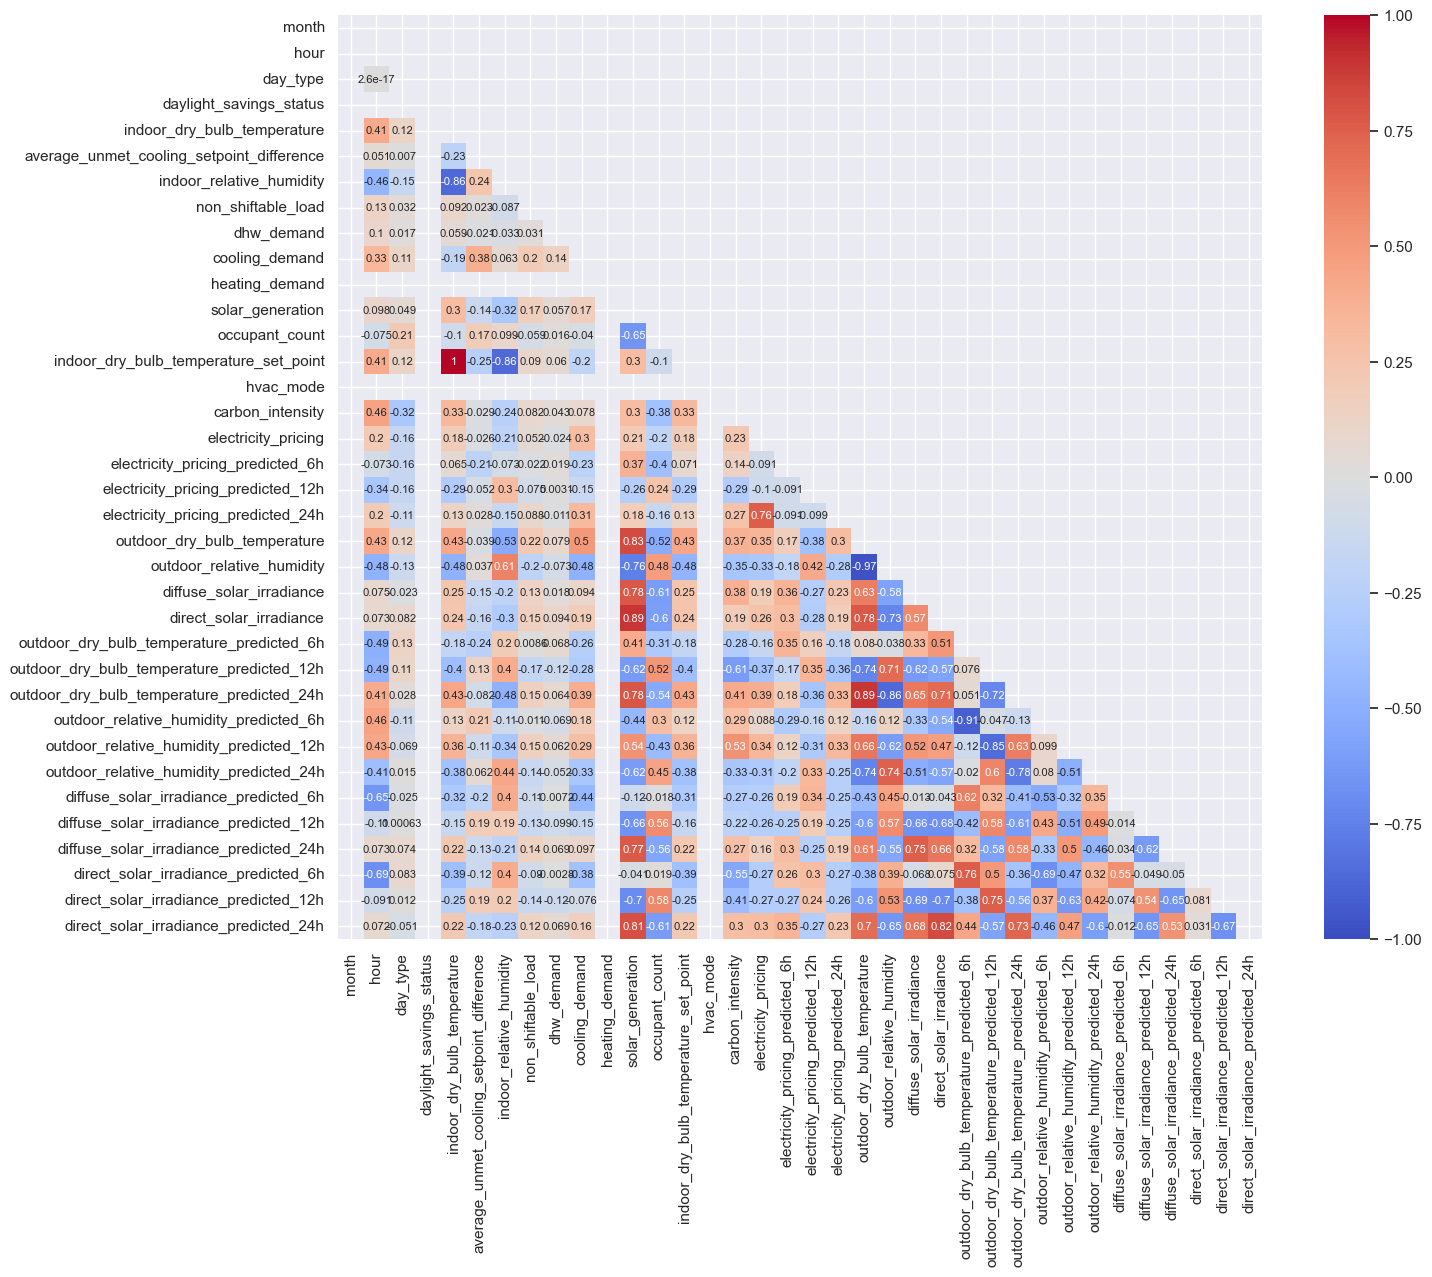

In [657]:
# Correlation matrix
corrmat = df.corr()

# Generate a mask for the upper triangle
matrix = np.triu(corrmat)
f, ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1)
sns.heatmap(corrmat, vmin=-1, vmax=1, center= 0, square=True, annot=True, annot_kws={'size': 8}, mask=matrix, fmt='.2g', cmap= 'coolwarm')

plt.show()

Ora seguiranno in ordine le predizioni relative a:

    1. cooling load
    2. dhw load
    3. non shiftable load

Predizione del cooling load

In [658]:
dataframe = df
# Standardizing data
sc= MinMaxScaler(feature_range=(-1,1))

target = 'cooling_demand'

features = ['month', 'hour', 'day_type', 'daylight_savings_status',
       'indoor_dry_bulb_temperature',
       'average_unmet_cooling_setpoint_difference', 'indoor_relative_humidity',
       'non_shiftable_load', 'dhw_demand', 'heating_demand',
       'solar_generation', 'occupant_count',
       'indoor_dry_bulb_temperature_set_point', 'hvac_mode',
       'carbon_intensity', 'electricity_pricing',
       'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h',
       'electricity_pricing_predicted_24h', 'outdoor_dry_bulb_temperature',
       'outdoor_relative_humidity', 'diffuse_solar_irradiance',
       'direct_solar_irradiance', 'outdoor_dry_bulb_temperature_predicted_6h',
       'outdoor_dry_bulb_temperature_predicted_12h',
       'outdoor_dry_bulb_temperature_predicted_24h',
       'outdoor_relative_humidity_predicted_6h',
       'outdoor_relative_humidity_predicted_12h',
       'outdoor_relative_humidity_predicted_24h',
       'diffuse_solar_irradiance_predicted_6h',
       'diffuse_solar_irradiance_predicted_12h',
       'diffuse_solar_irradiance_predicted_24h',
       'direct_solar_irradiance_predicted_6h',
       'direct_solar_irradiance_predicted_12h',
       'direct_solar_irradiance_predicted_24h']

for var in features:
    if(var != 'cooling_demand'):
        dataframe[var] = sc.fit_transform(dataframe[var].values.reshape(-1, 1))

In [659]:
#NumPy representation of the data frame (removing labels)
dataframe = pd.DataFrame(data=dataframe)

X = dataframe.drop(columns='cooling_demand')
X = X.to_numpy()

Y = dataframe['cooling_demand']
Y = Y.to_numpy()


seed = 7
np.random.seed(seed)

# split dataset in 70% for traininig and 30% for testing (500 -> 375,125)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

# split training in 80% for traininig and 20% for validating (375 -> 300,75)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=seed)#insert your code here

# Model creation (choose between tiny, small, medium and large by using the appropriate function)
model = create_model_large()
model.summary()


c:\Users\Simone\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_282 (Dense)               │ (None, 35)             │         1,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 70)             │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 35)             │         2,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_285 (Dense)               │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,301 (24.61 KB)

 Trainable params: 6,301 (24.61 KB)

 Non-trainable params: 0 (0.00 B)

In [660]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=32)

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 12.4041 - mean_absolute_error: 3.0782 - val_loss: 7.5272 - val_mean_absolute_error: 2.1569
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2033 - mean_absolute_error: 1.9937 - val_loss: 3.4109 - val_mean_absolute_error: 1.4075
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6359 - mean_absolute_error: 1.5121 - val_loss: 2.6452 - val_mean_absolute_error: 1.3231
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9229 - mean_absolute_error: 1.3262 - val_loss: 2.0256 - val_mean_absolute_error: 1.1246
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7514 - mean_absolute_error: 1.2945 - val_loss: 1.8130 - val_mean_absolute_error: 1.0668
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9094 - mean_absolute_error: 1.0690 - val_loss: 1.6334 - val_mean_absolute_error: 1.0158
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7986 - mean_absolute_error: 1.0496 - val_lo

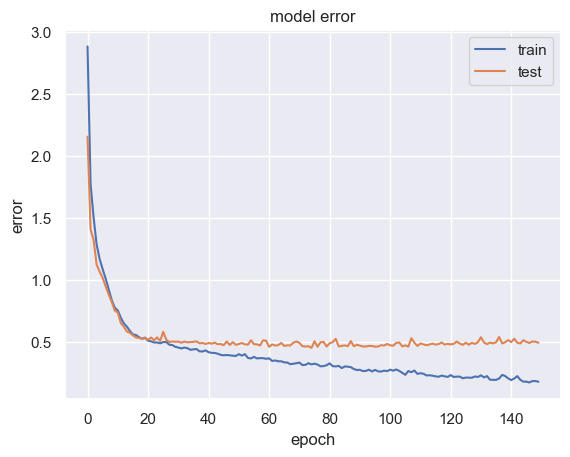

In [661]:
# Summarize history for error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

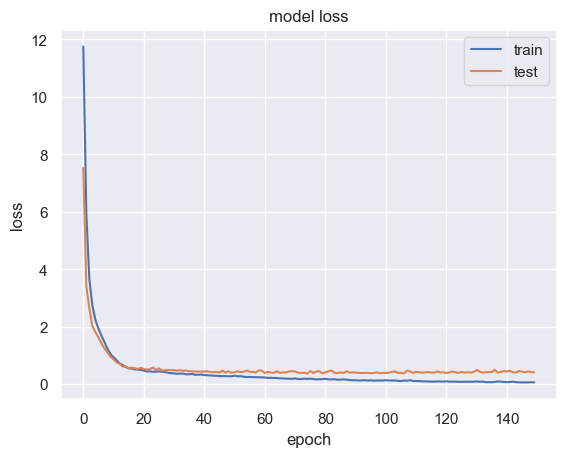

In [662]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [663]:
# Prediction
pred = model.predict(X_test).reshape(1,-1)[0]

nrmse_cooling = NRMSE(y_test, pred)


print("nrmse : ",nrmse_cooling)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
nrmse :  0.2260479736240162


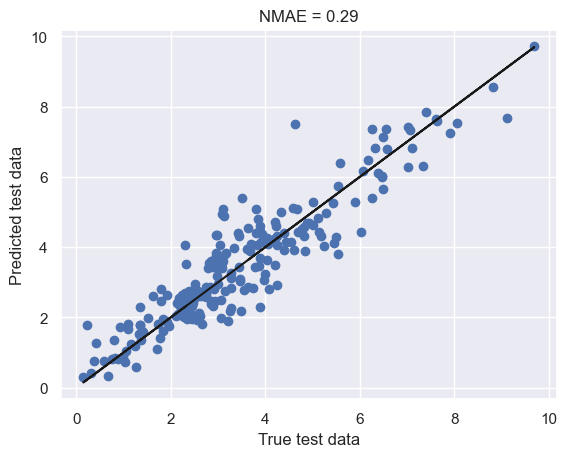

In [664]:
plt.scatter(y_test, pred)
plt.title(r"NMAE = %.2f" % (np.abs(y_test - pred).mean()/y_test.std()))
plt.plot(y_test, y_test, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
plt.show()

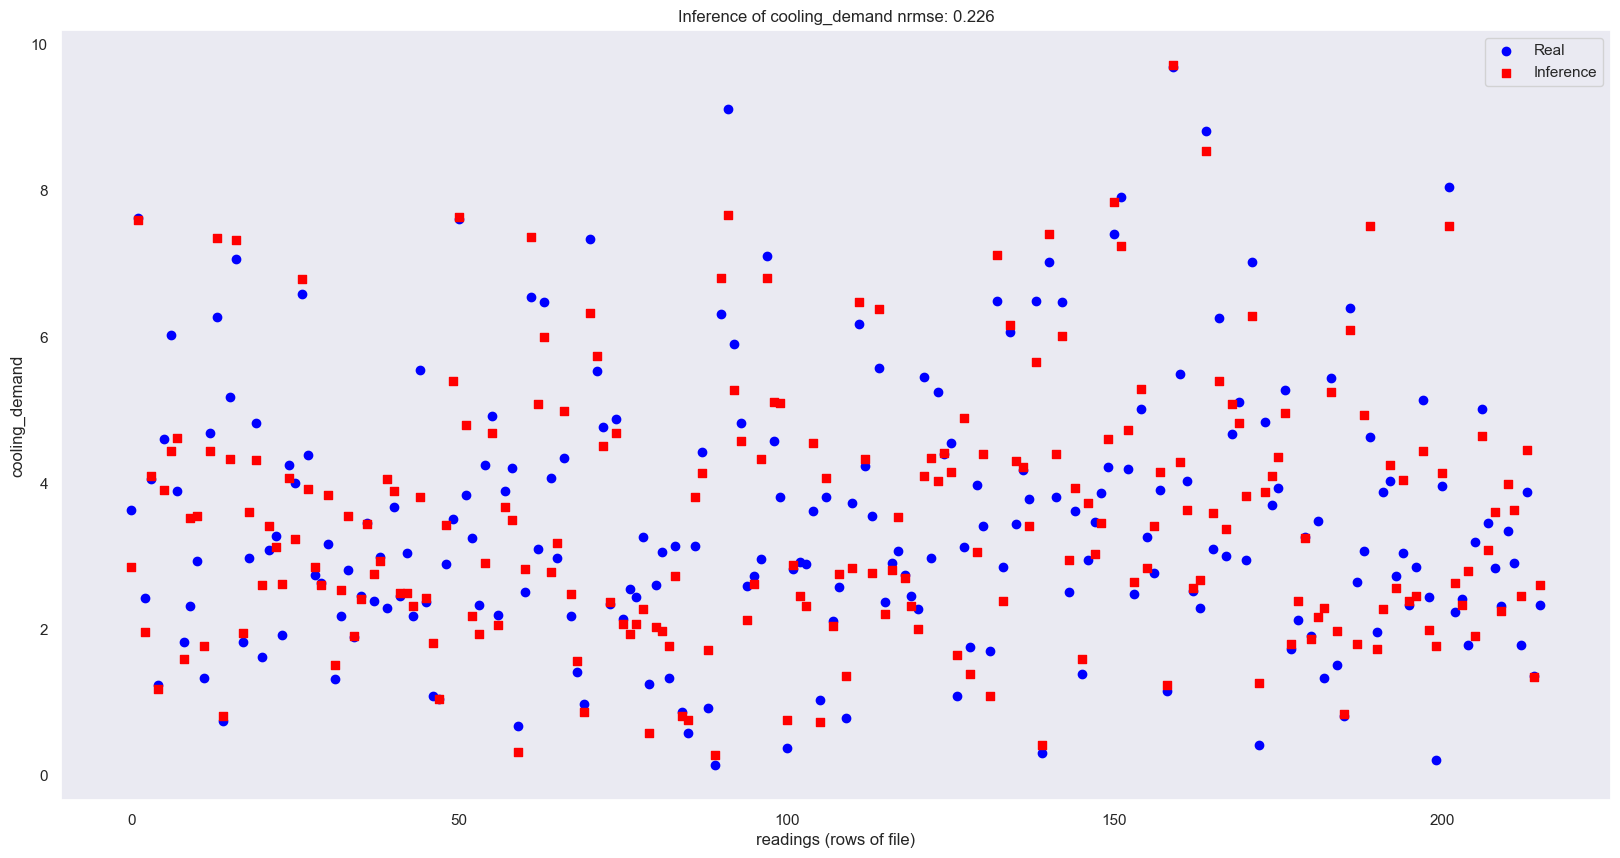

In [665]:
my_x=np.arange(0,len(X_test[:, 0]),1)

fig = plt.figure(figsize=(20,10))
plt.scatter(my_x, y_test, label='Real', color='blue', marker='o')
plt.scatter(my_x, pred, label='Inference', color='red', marker='s')
plt.title(f'Inference of cooling_demand nrmse: {nrmse_cooling:.3f}')
plt.ylabel('cooling_demand')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.legend()
plt.show()

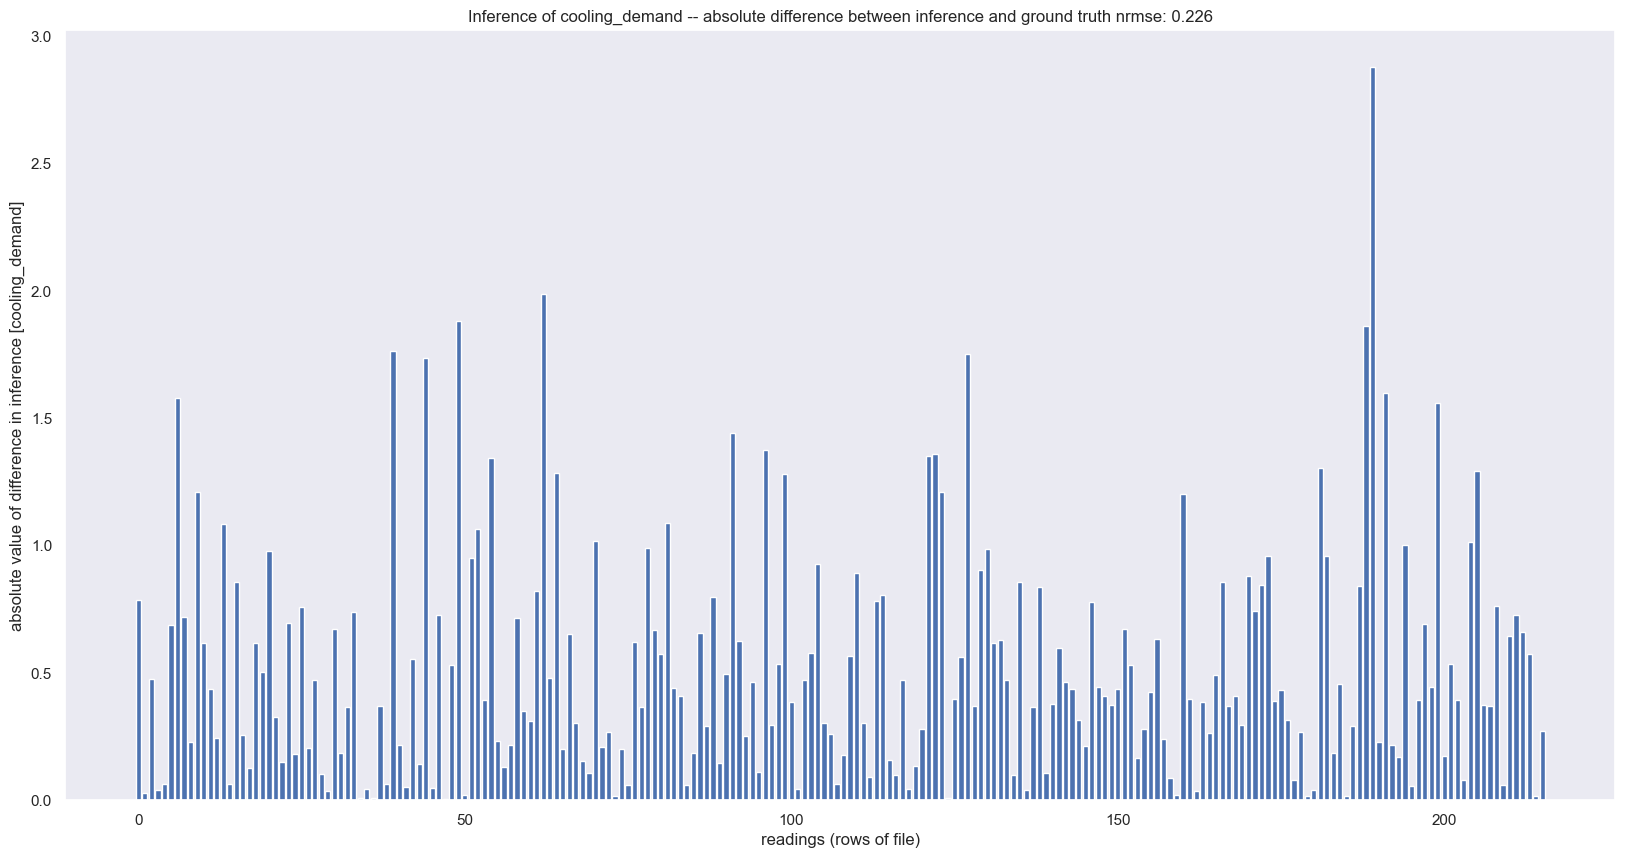

In [666]:
fig = plt.figure(figsize=(20,10))
my_d = abs(y_test-pred)

plt.bar(my_x,my_d)
plt.title(f'Inference of cooling_demand -- absolute difference between inference and ground truth nrmse: {nrmse_cooling:.3f}')
plt.ylabel('absolute value of difference in inference [cooling_demand]')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.show()

In [667]:
w = 48

nrmse_single_cooling = NRMSE_window_single_variable(y_test, pred, w)
print("NRMSE per singola variabile con finestra temporale:", nrmse_single_cooling)

NRMSE per singola variabile con finestra temporale: 0.24042827304856154


Predizione del dhw load

In [668]:
# Standardizing data
sc= MinMaxScaler(feature_range=(-1,1))

dataframe = df

target = 'dhw_demand'

features = ['month', 'hour', 'day_type', 'daylight_savings_status',
       'indoor_dry_bulb_temperature',
       'average_unmet_cooling_setpoint_difference', 'indoor_relative_humidity',
       'non_shiftable_load', 'cooling_demand', 'heating_demand',
       'solar_generation', 'occupant_count',
       'indoor_dry_bulb_temperature_set_point', 'hvac_mode',
       'carbon_intensity', 'electricity_pricing',
       'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h',
       'electricity_pricing_predicted_24h', 'outdoor_dry_bulb_temperature',
       'outdoor_relative_humidity', 'diffuse_solar_irradiance',
       'direct_solar_irradiance', 'outdoor_dry_bulb_temperature_predicted_6h',
       'outdoor_dry_bulb_temperature_predicted_12h',
       'outdoor_dry_bulb_temperature_predicted_24h',
       'outdoor_relative_humidity_predicted_6h',
       'outdoor_relative_humidity_predicted_12h',
       'outdoor_relative_humidity_predicted_24h',
       'diffuse_solar_irradiance_predicted_6h',
       'diffuse_solar_irradiance_predicted_12h',
       'diffuse_solar_irradiance_predicted_24h',
       'direct_solar_irradiance_predicted_6h',
       'direct_solar_irradiance_predicted_12h',
       'direct_solar_irradiance_predicted_24h']

for var in features:
    if(var != 'dhw_demand'):
        dataframe[var] = sc.fit_transform(dataframe[var].values.reshape(-1, 1))

In [669]:
#NumPy representation of the data frame (removing labels)
dataframe = pd.DataFrame(data=dataframe)

X = dataframe.drop(columns='dhw_demand')
X = X.to_numpy()

Y = dataframe['dhw_demand']
Y = Y.to_numpy()


seed = 7
np.random.seed(seed)

# split dataset in 70% for traininig and 30% for testing (500 -> 375,125)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

# split training in 80% for traininig and 20% for validating (375 -> 300,75)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=seed)#insert your code here

# Model creation (choose between tiny, small, medium and large by using the appropriate function)
model = create_model_large()
model.summary()

c:\Users\Simone\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_286 (Dense)               │ (None, 35)             │         1,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_287 (Dense)               │ (None, 70)             │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 35)             │         2,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,301 (24.61 KB)

 Trainable params: 6,301 (24.61 KB)

 Non-trainable params: 0 (0.00 B)

In [670]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=32)

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2635 - mean_absolute_error: 0.4370 - val_loss: 0.0932 - val_mean_absolute_error: 0.2075
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0508 - mean_absolute_error: 0.1679 - val_loss: 0.0705 - val_mean_absolute_error: 0.1836
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0416 - mean_absolute_error: 0.1358 - val_loss: 0.0571 - val_mean_absolute_error: 0.1470
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0392 - mean_absolute_error: 0.1336 - val_loss: 0.0547 - val_mean_absolute_error: 0.1456
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0398 - mean_absolute_error: 0.1177 - val_loss: 0.0540 - val_mean_absolute_error: 0.1459
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0432 - mean_absolute_error: 0.1224 - val_loss: 0.0552 - val_mean_absolute_error: 0.1431
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0339 - mean_absolute_error: 0.1108 - val_los

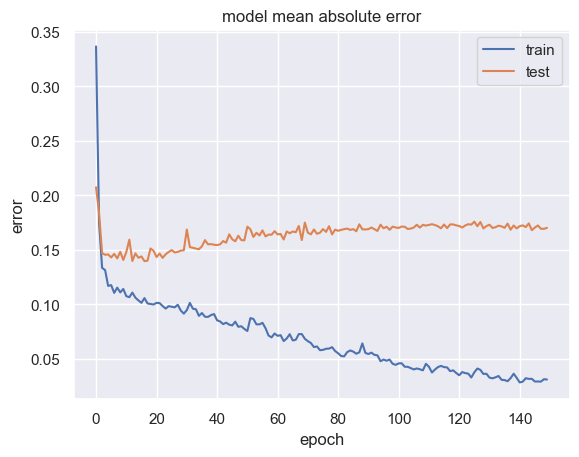

In [671]:
# Summarize history for error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean absolute error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

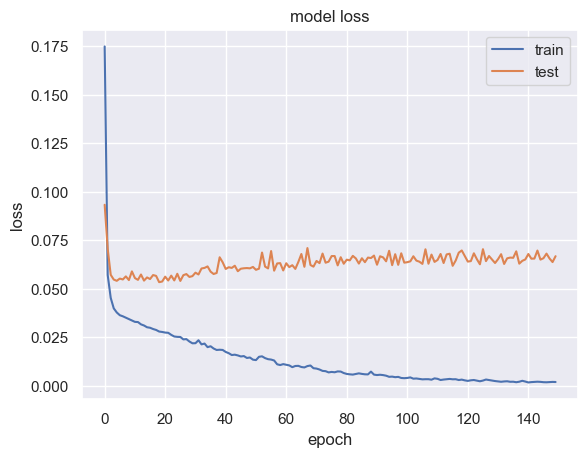

In [672]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [673]:
# Prediction
pred = model.predict(X_test).reshape(1,-1)[0]

nrmse_dhw = NRMSE(y_test, pred)


print("nrmse : ",nrmse_dhw)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
nrmse :  0.20721291327912836


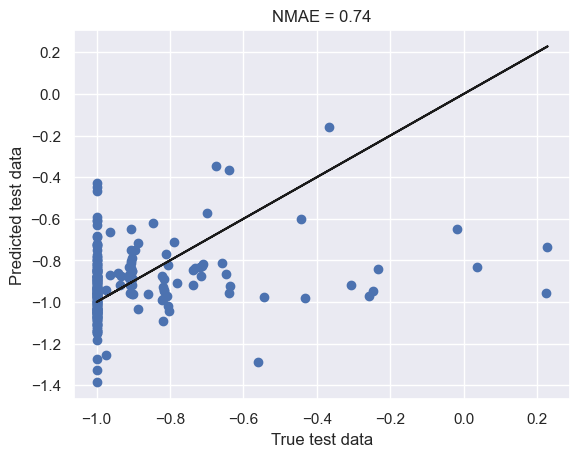

In [674]:
plt.scatter(y_test, pred)
plt.title(r"NMAE = %.2f" % (np.abs(y_test - pred).mean()/y_test.std()))
plt.plot(y_test, y_test, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
plt.show()

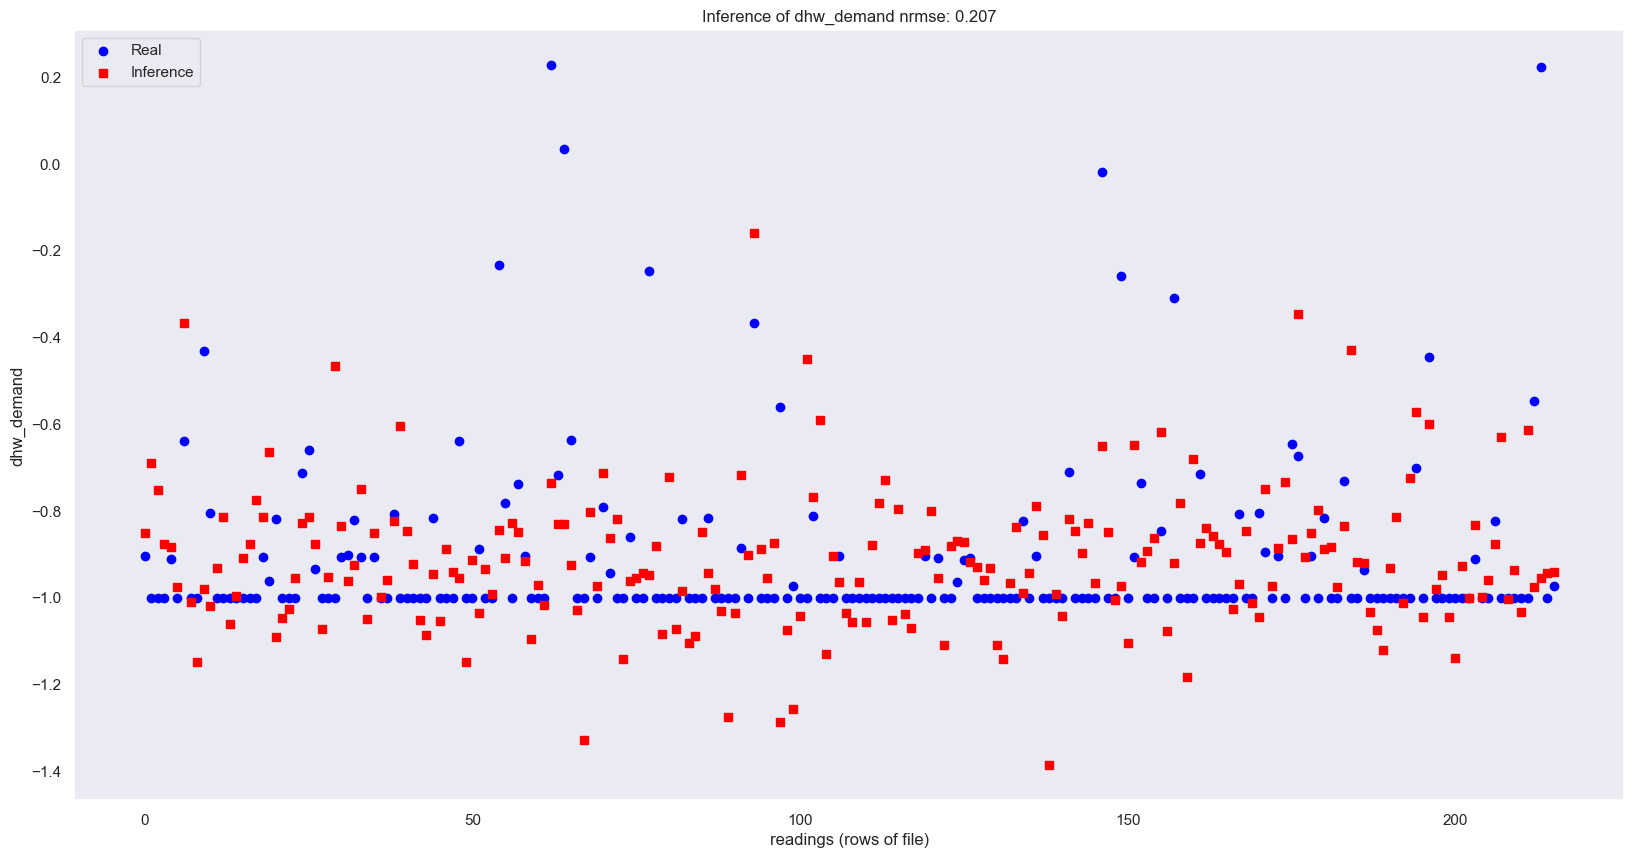

In [675]:
my_x=np.arange(0,len(X_test[:, 0]),1)

fig = plt.figure(figsize=(20,10))
plt.scatter(my_x, y_test, label='Real', color='blue', marker='o')
plt.scatter(my_x, pred, label='Inference', color='red', marker='s')
plt.title(f'Inference of dhw_demand nrmse: {nrmse_dhw:.3f}')
plt.ylabel('dhw_demand')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.legend()
plt.show()

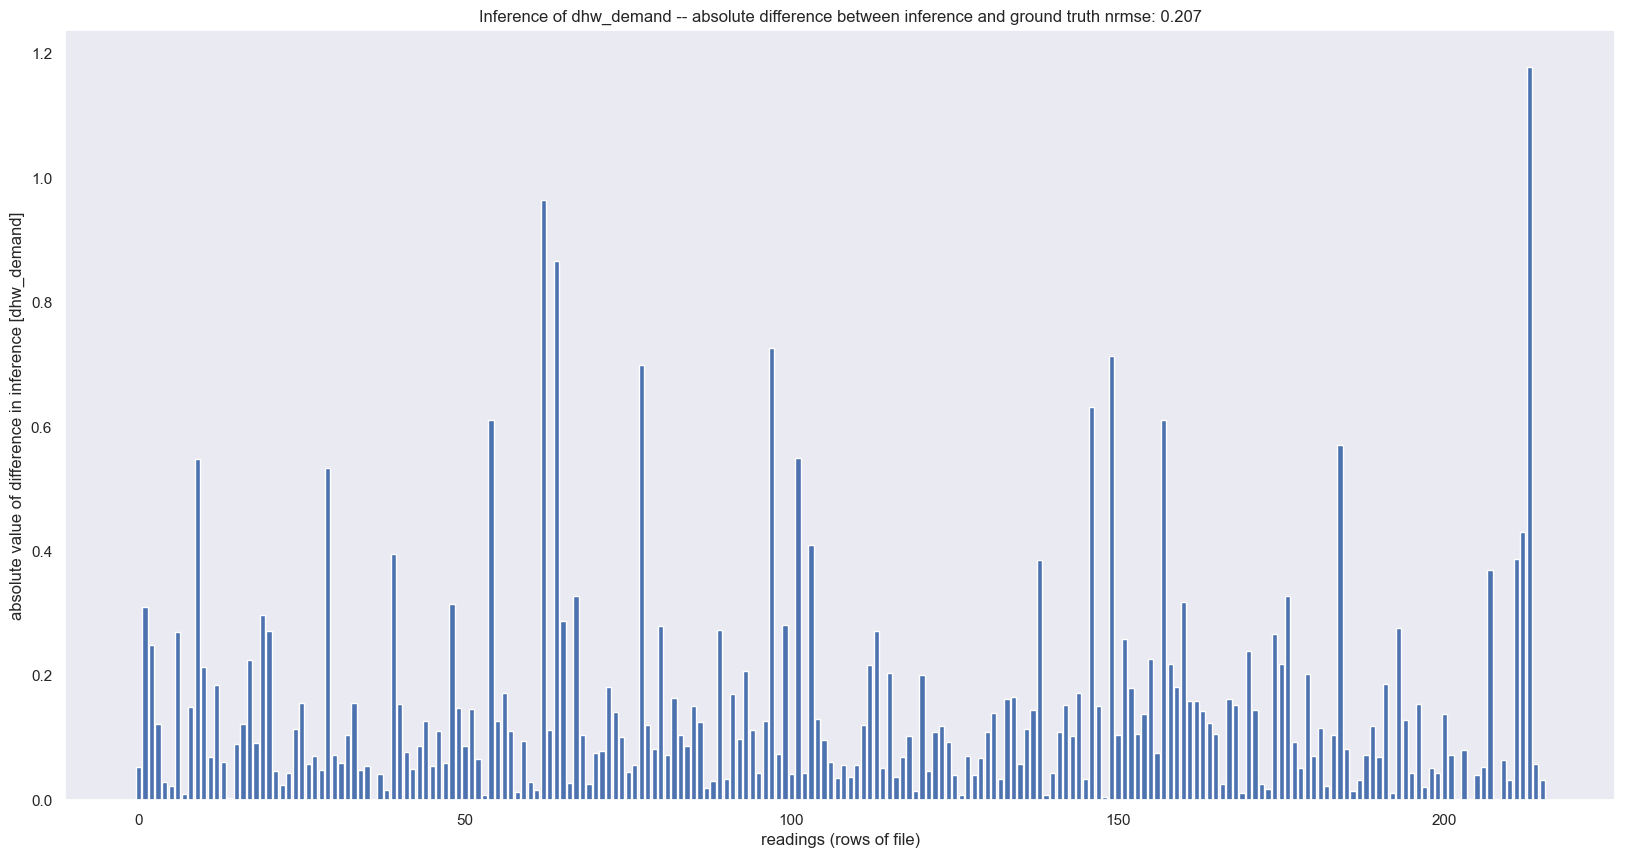

In [676]:
fig = plt.figure(figsize=(20,10))
my_d = abs(y_test-pred)

plt.bar(my_x,my_d)
plt.title(f'Inference of dhw_demand -- absolute difference between inference and ground truth nrmse: {nrmse_dhw:.3f}')
plt.ylabel('absolute value of difference in inference [dhw_demand]')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.show()

In [677]:
w = 48

nrmse_single_dhw = NRMSE_window_single_variable(y_test, pred, w)
print("NRMSE per singola variabile con finestra temporale:", nrmse_single_dhw)

NRMSE per singola variabile con finestra temporale: 0.23305232107645935


Predizione del non shiftable load

In [678]:
# Standardizing data
sc= MinMaxScaler(feature_range=(-1,1))

dataframe = df

target = 'non_shiftable_load'

features = ['month', 'hour', 'day_type', 'daylight_savings_status',
       'indoor_dry_bulb_temperature',
       'average_unmet_cooling_setpoint_difference', 'indoor_relative_humidity',
       'dhw_demand', 'cooling_demand', 'heating_demand',
       'solar_generation', 'occupant_count',
       'indoor_dry_bulb_temperature_set_point', 'hvac_mode',
       'carbon_intensity', 'electricity_pricing',
       'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h',
       'electricity_pricing_predicted_24h', 'outdoor_dry_bulb_temperature',
       'outdoor_relative_humidity', 'diffuse_solar_irradiance',
       'direct_solar_irradiance', 'outdoor_dry_bulb_temperature_predicted_6h',
       'outdoor_dry_bulb_temperature_predicted_12h',
       'outdoor_dry_bulb_temperature_predicted_24h',
       'outdoor_relative_humidity_predicted_6h',
       'outdoor_relative_humidity_predicted_12h',
       'outdoor_relative_humidity_predicted_24h',
       'diffuse_solar_irradiance_predicted_6h',
       'diffuse_solar_irradiance_predicted_12h',
       'diffuse_solar_irradiance_predicted_24h',
       'direct_solar_irradiance_predicted_6h',
       'direct_solar_irradiance_predicted_12h',
       'direct_solar_irradiance_predicted_24h']

for var in features:
    if(var != 'non_shiftable_load'):
        dataframe[var] = sc.fit_transform(dataframe[var].values.reshape(-1, 1))

In [679]:
#NumPy representation of the data frame (removing labels)
dataframe = pd.DataFrame(data=dataframe)

X = dataframe.drop(columns='non_shiftable_load')
X = X.to_numpy()

Y = dataframe['non_shiftable_load']
Y = Y.to_numpy()


seed = 7
np.random.seed(seed)

# split dataset in 70% for traininig and 30% for testing (500 -> 375,125)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

# split training in 80% for traininig and 20% for validating (375 -> 300,75)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=seed)#insert your code here

# Model creation (choose between tiny, small, medium and large by using the appropriate function)
model = create_model_large()
model.summary()

c:\Users\Simone\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_290 (Dense)               │ (None, 35)             │         1,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_291 (Dense)               │ (None, 70)             │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_292 (Dense)               │ (None, 35)             │         2,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,301 (24.61 KB)

 Trainable params: 6,301 (24.61 KB)

 Non-trainable params: 0 (0.00 B)

In [680]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=32)

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2497 - mean_absolute_error: 0.4090 - val_loss: 0.0656 - val_mean_absolute_error: 0.1762
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0696 - mean_absolute_error: 0.1596 - val_loss: 0.0451 - val_mean_absolute_error: 0.1535
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0554 - mean_absolute_error: 0.1401 - val_loss: 0.0352 - val_mean_absolute_error: 0.1096
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0434 - mean_absolute_error: 0.1100 - val_loss: 0.0331 - val_mean_absolute_error: 0.1101
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0465 - mean_absolute_error: 0.1210 - val_loss: 0.0334 - val_mean_absolute_error: 0.1065
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0449 - mean_absolute_error: 0.1112 - val_loss: 0.0328 - val_mean_absolute_error: 0.1042
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0368 - mean_absolute_error: 0.1056 - val_los

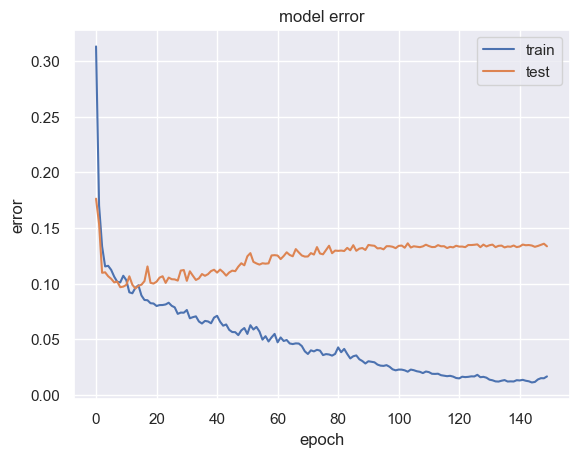

In [681]:
# Summarize history for error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

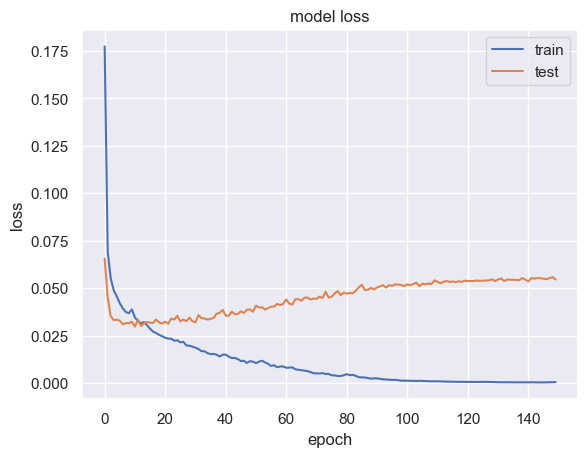

In [682]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [683]:
# Prediction
pred = model.predict(X_test).reshape(1,-1)[0]

nrmse_nonshiftable = NRMSE(y_test, pred)


print("nrmse : ",nrmse_nonshiftable)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
nrmse :  0.2094196575892243


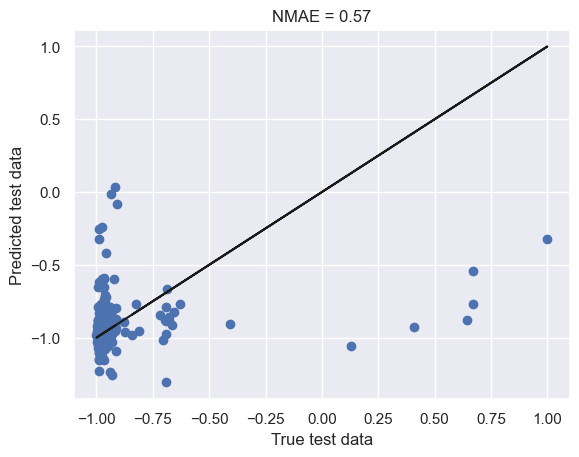

In [684]:
plt.scatter(y_test, pred)
plt.title(r"NMAE = %.2f" % (np.abs(y_test - pred).mean()/y_test.std()))
plt.plot(y_test, y_test, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
plt.show()

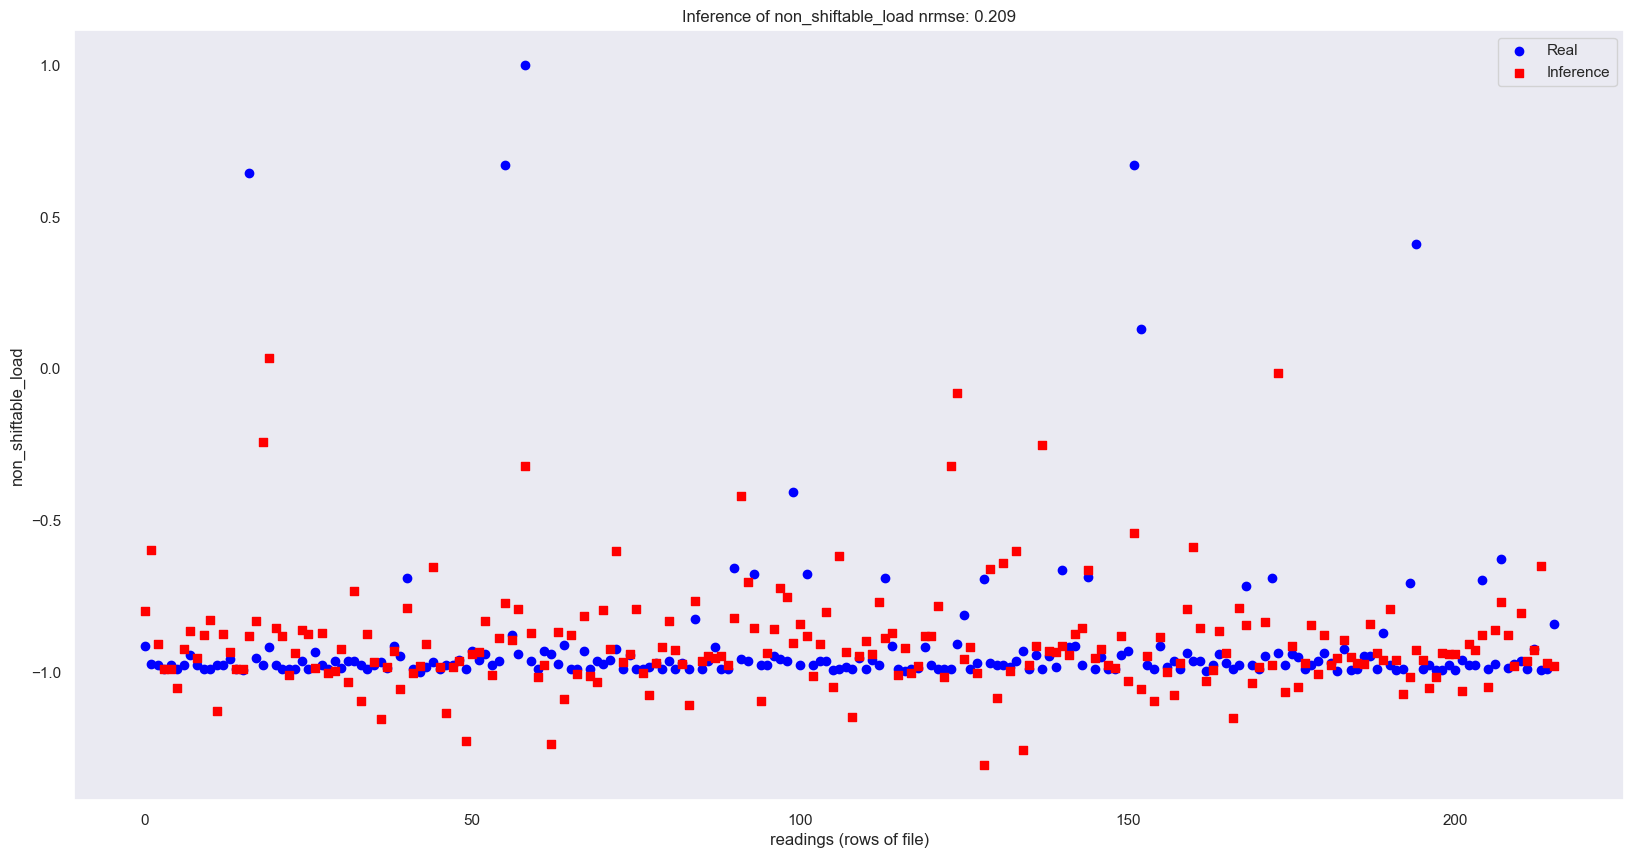

In [685]:
my_x=np.arange(0,len(X_test[:, 0]),1)

fig = plt.figure(figsize=(20,10))
plt.scatter(my_x, y_test, label='Real', color='blue', marker='o')
plt.scatter(my_x, pred, label='Inference', color='red', marker='s')
plt.title(f'Inference of non_shiftable_load nrmse: {nrmse_nonshiftable:.3f}')
plt.ylabel('non_shiftable_load')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.legend()
plt.show()

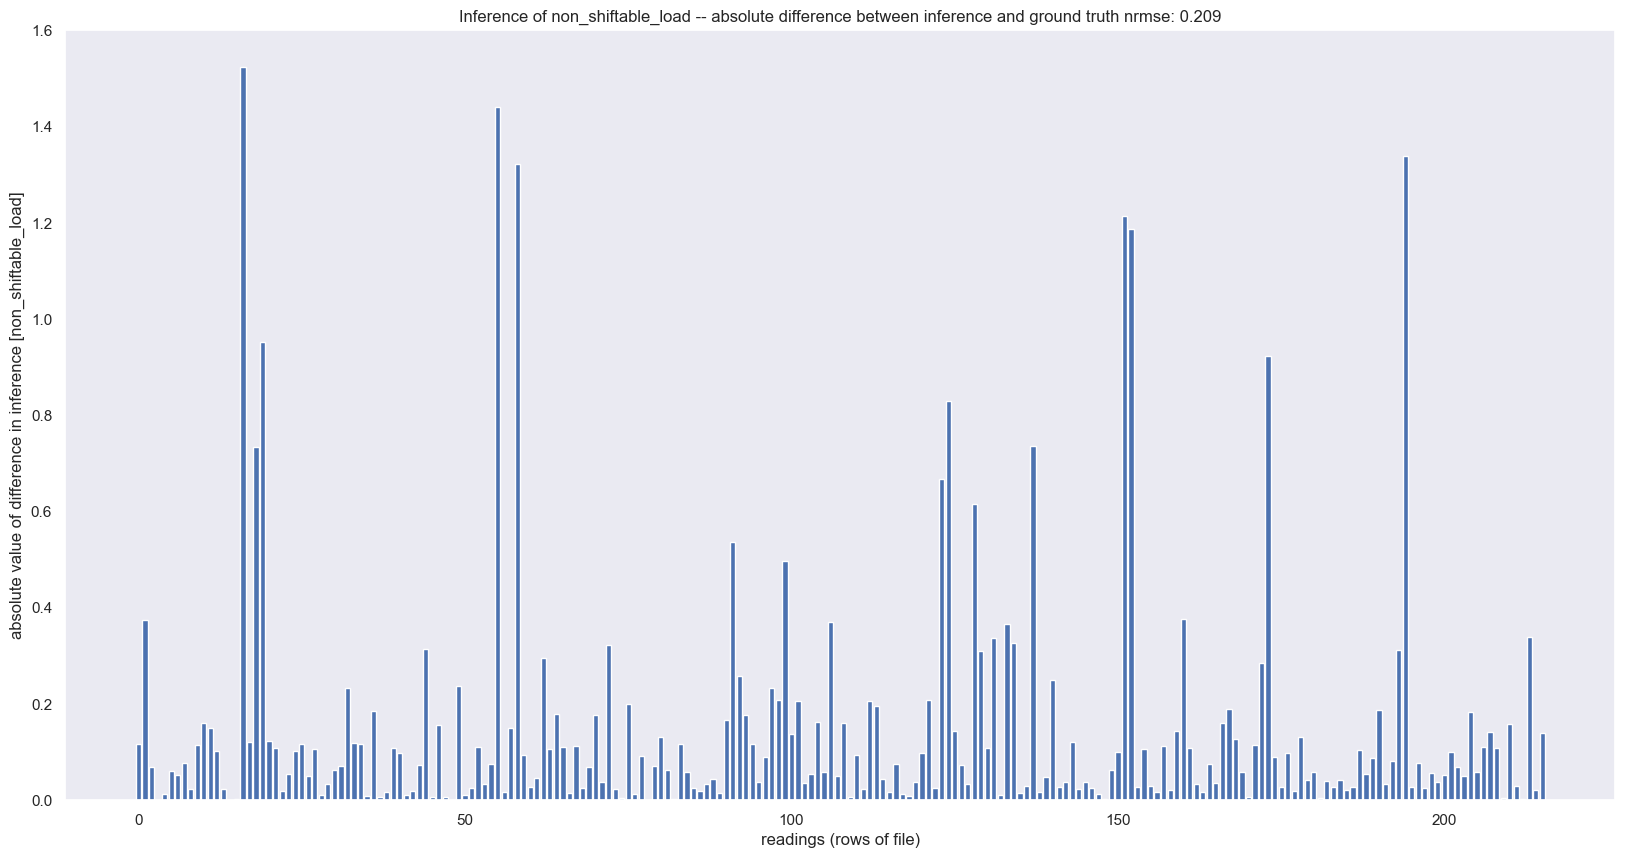

In [686]:
fig = plt.figure(figsize=(20,10))
my_d = abs(y_test-pred)

plt.bar(my_x,my_d)
plt.title(f'Inference of non_shiftable_load -- absolute difference between inference and ground truth nrmse: {nrmse_nonshiftable:.3f}')
plt.ylabel('absolute value of difference in inference [non_shiftable_load]')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.show()

In [687]:
w = 48

nrmse_single_non_shiftable = NRMSE_window_single_variable(y_test, pred, w)
print("NRMSE per singola variabile con finestra temporale:", nrmse_single_non_shiftable)

NRMSE per singola variabile con finestra temporale: 0.2549103290787295


In [688]:
#non riuscendo a capire molto dalla sola formula ho provato a "tradurre" la definizione e ho dato due soluzioni

#questo ScoreForecast è dato dalla somma di tutte le NRMSE calcolate precedentemente e divise per il numero totale di variabili
ScoreForecast = (nrmse_nonshiftable + nrmse_cooling + nrmse_dhw) / 3
print(f"La media, su tutte le variabili previste, dell'errore quadratico medio normalizzato (NRMSE) delle previsioni effettuate: {ScoreForecast:.3f}.")

La media, su tutte le variabili previste, dell'errore quadratico medio normalizzato (NRMSE) delle previsioni effettuate: 0.214.


In [689]:
#questo invece è dato dalla somma di tutte le NRMSE tenendo conto di una finestra temporale (48h), e si dovrebbe avvicinare alla formula
ScoreForecast = (nrmse_single_non_shiftable + nrmse_single_cooling + nrmse_single_dhw) / 3
print(f"La media, su tutte le variabili previste, dell'errore quadratico medio normalizzato (NRMSE) delle previsioni effettuate: {ScoreForecast:.3f}.")

La media, su tutte le variabili previste, dell'errore quadratico medio normalizzato (NRMSE) delle previsioni effettuate: 0.243.
